In [11]:
# Paths
RAW_DIR = "../data/raw/cicids_simplified"
PROC_BIN_DIR = "../data/processed"         # from --target binary
PROC_FIVE_DIR = "../data/processed_five"   # from --target fiveclass

# Imports
import os, pathlib, numpy as np, pandas as pd, matplotlib.pyplot as plt, seaborn as sns
from pathlib import Path

# Make figs dir
Path("report/figs").mkdir(parents=True, exist_ok=True)

# Matplotlib defaults
plt.rcParams["figure.dpi"] = 140
sns.set_context("talk")


In [12]:
def load_splits(dir_):
    dir_ = Path(dir_)
    tr = pd.read_csv(dir_/"train.csv")
    va = pd.read_csv(dir_/"val.csv")
    te = pd.read_csv(dir_/"test.csv")
    return tr, va, te

bin_tr, bin_va, bin_te   = load_splits(PROC_BIN_DIR)
five_tr, five_va, five_te = load_splits(PROC_FIVE_DIR)

raw_df = pd.read_csv(f"{RAW_DIR}/basic_data_4.csv")
raw_df.columns = raw_df.columns.str.strip().str.lower()


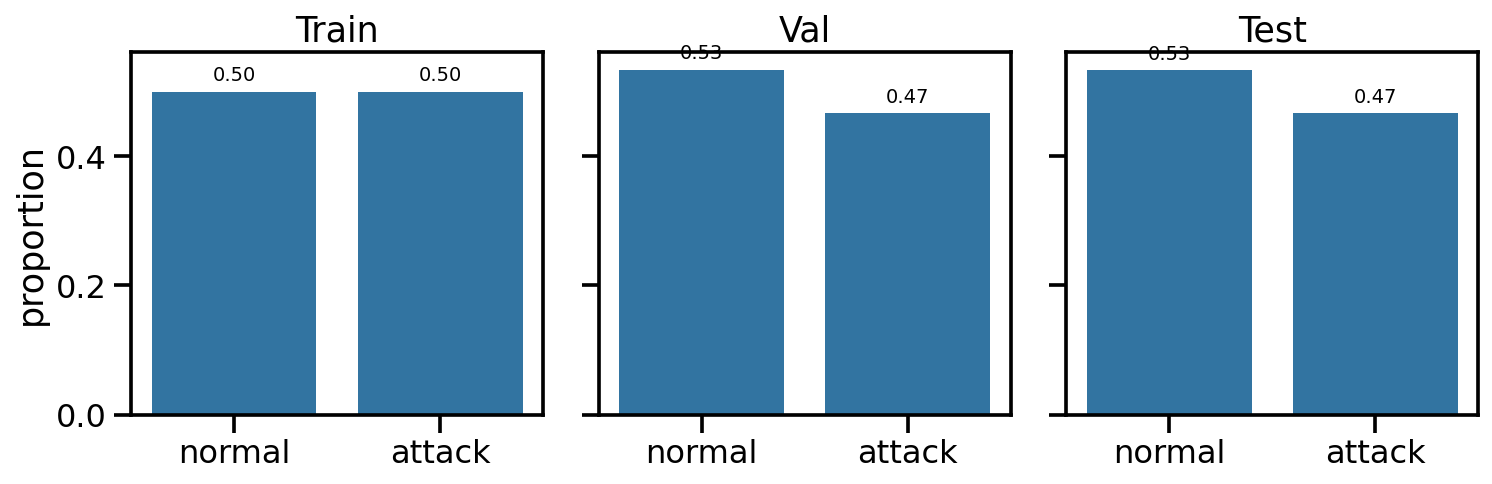

In [13]:
def plot_class_balance_binary(tr, va, te, out="report/figs/class_balance_binary.png"):
    fig, axes = plt.subplots(1, 3, figsize=(11, 3.8), sharey=True)
    for ax, df, title in zip(axes, [tr, va, te], ["Train", "Val", "Test"]):
        vc = df["label"].value_counts(normalize=True).sort_index().rename({0:"normal",1:"attack"})
        sns.barplot(x=vc.index, y=vc.values, ax=ax)
        ax.set_title(title); ax.set_ylabel("proportion"); ax.set_xlabel("")
        for p, v in zip(ax.patches, vc.values):
            ax.text(p.get_x()+p.get_width()/2, p.get_height()+0.01, f"{v:.2f}", ha="center", va="bottom", fontsize=10)
    plt.tight_layout()
    plt.savefig(out); plt.show()

plot_class_balance_binary(bin_tr, bin_va, bin_te)


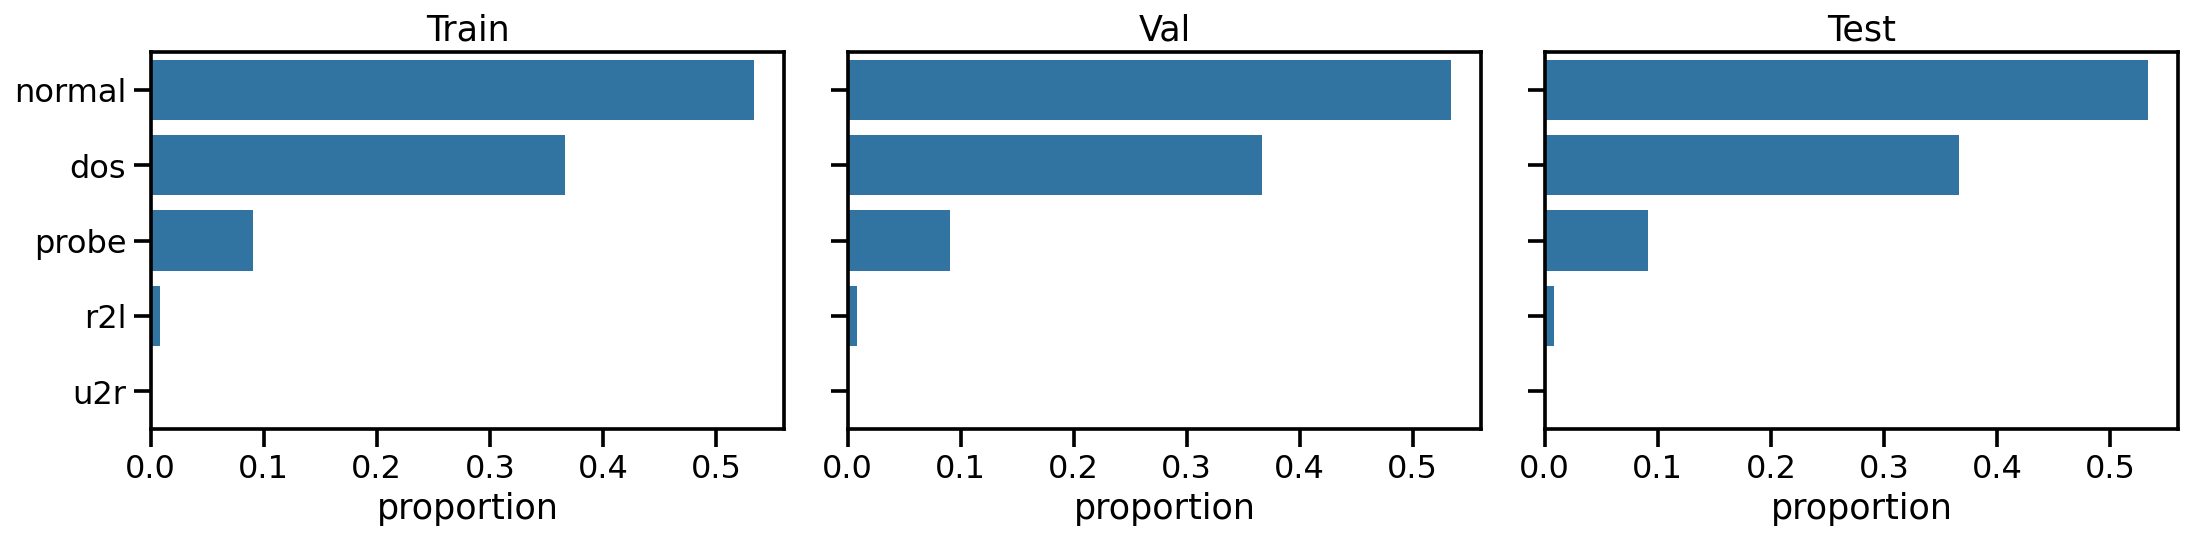

In [14]:
def plot_class_balance_five(tr, va, te, out="report/figs/class_balance_fiveclass.png"):
    fig, axes = plt.subplots(1, 3, figsize=(16, 4.2), sharey=True)
    for ax, df, title in zip(axes, [tr, va, te], ["Train", "Val", "Test"]):
        vc = df["label"].astype(str).value_counts(normalize=True)
        sns.barplot(y=vc.index, x=vc.values, ax=ax, orient="h")
        ax.set_title(title); ax.set_xlabel("proportion"); ax.set_ylabel("")
    plt.tight_layout()
    plt.savefig(out); plt.show()

plot_class_balance_five(five_tr, five_va, five_te)


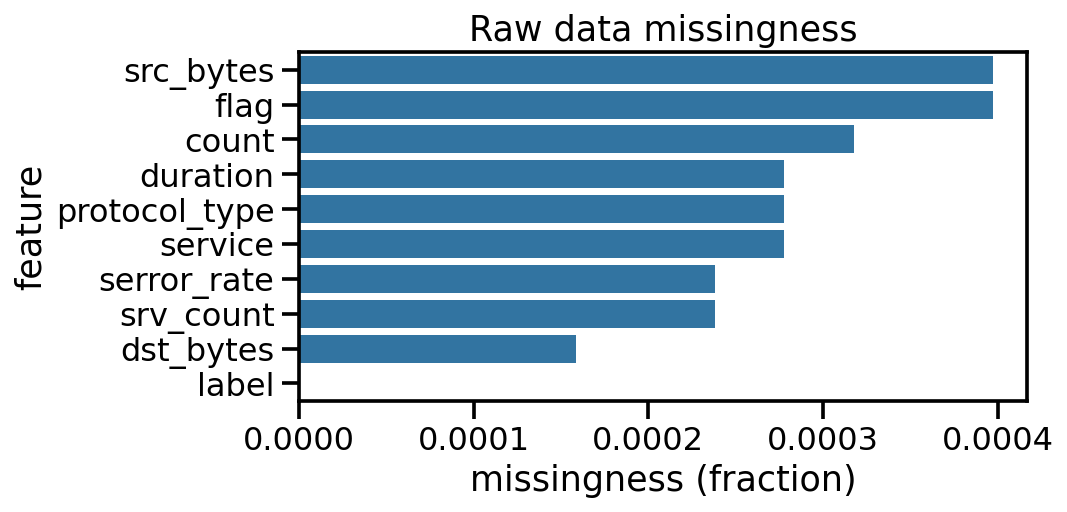

In [15]:
def plot_missingness(df, out="report/figs/missingness_raw.png"):
    miss = df.isna().mean().sort_values(ascending=False)
    fig = plt.figure(figsize=(8,4))
    sns.barplot(x=miss.values, y=miss.index)
    plt.xlabel("missingness (fraction)"); plt.ylabel("feature")
    plt.title("Raw data missingness")
    plt.tight_layout(); plt.savefig(out); plt.show()

plot_missingness(raw_df)


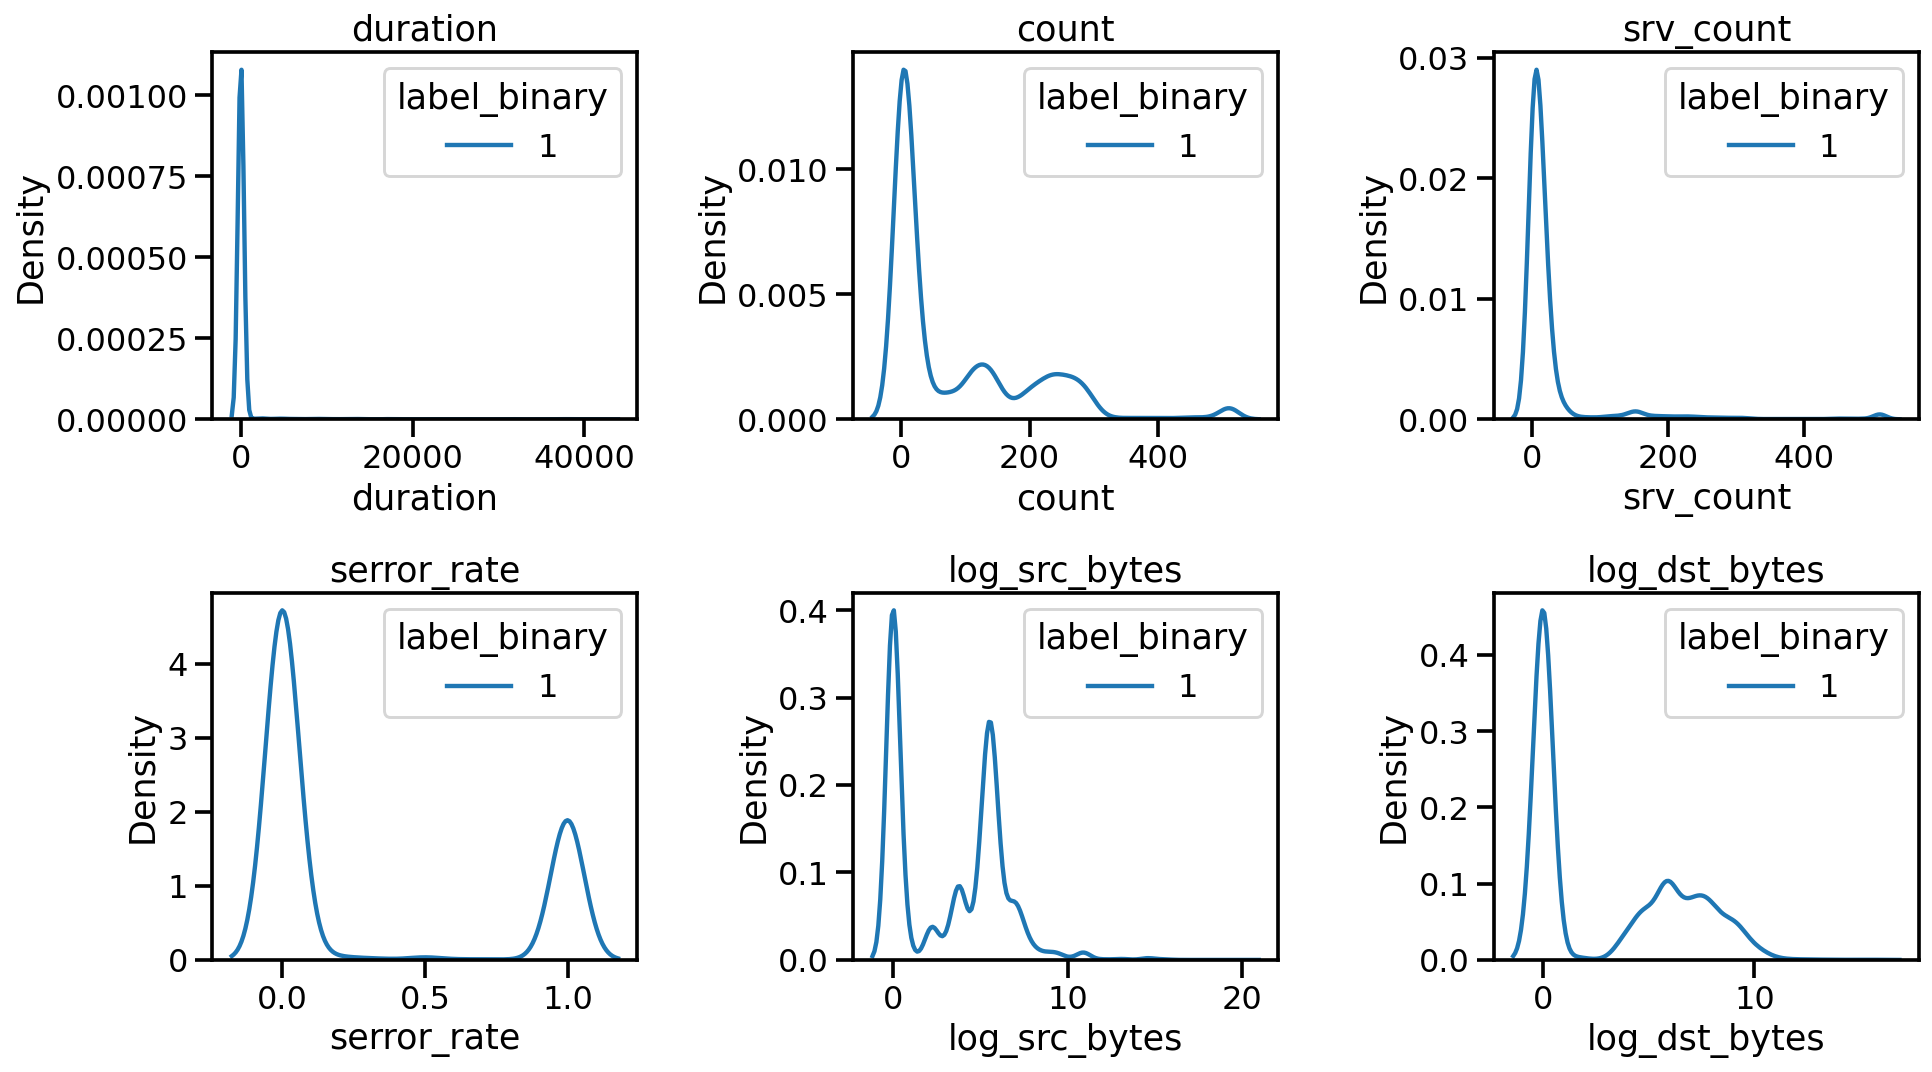

In [16]:
# Map raw label
labmap = pd.read_csv(f"{RAW_DIR}/label_category_map.csv")
labmap.columns = labmap.columns.str.strip().str.lower()
raw_df["label"] = raw_df["label"].astype(str).str.lower().str.strip()
raw_df = raw_df.merge(labmap, left_on="label", right_on=labmap.columns[0], how="left")
raw_df["label_binary"] = (raw_df["category"].fillna("normal") != "normal").astype(int)

num_cols = ["duration","src_bytes","dst_bytes","count","srv_count","serror_rate"]

for c in ["src_bytes","dst_bytes"]:
    raw_df[f"log_{c}"] = np.log1p(raw_df[c].clip(lower=0))

def dist_grid(df, cols, hue, out="report/figs/numeric_distributions_binary.png"):
    n = len(cols); ncols = 3; nrows = int(np.ceil(n/ncols))
    fig, axes = plt.subplots(nrows, ncols, figsize=(14, 4*nrows))
    axes = axes.flatten()
    for ax, c in zip(axes, cols):
        sns.kdeplot(data=df, x=c, hue=hue, common_norm=False, ax=ax)
        ax.set_title(c)
    for ax in axes[n:]:
        ax.axis("off")
    plt.tight_layout(); plt.savefig(out); plt.show()

dist_grid(raw_df, ["duration","count","srv_count","serror_rate","log_src_bytes","log_dst_bytes"], "label_binary")


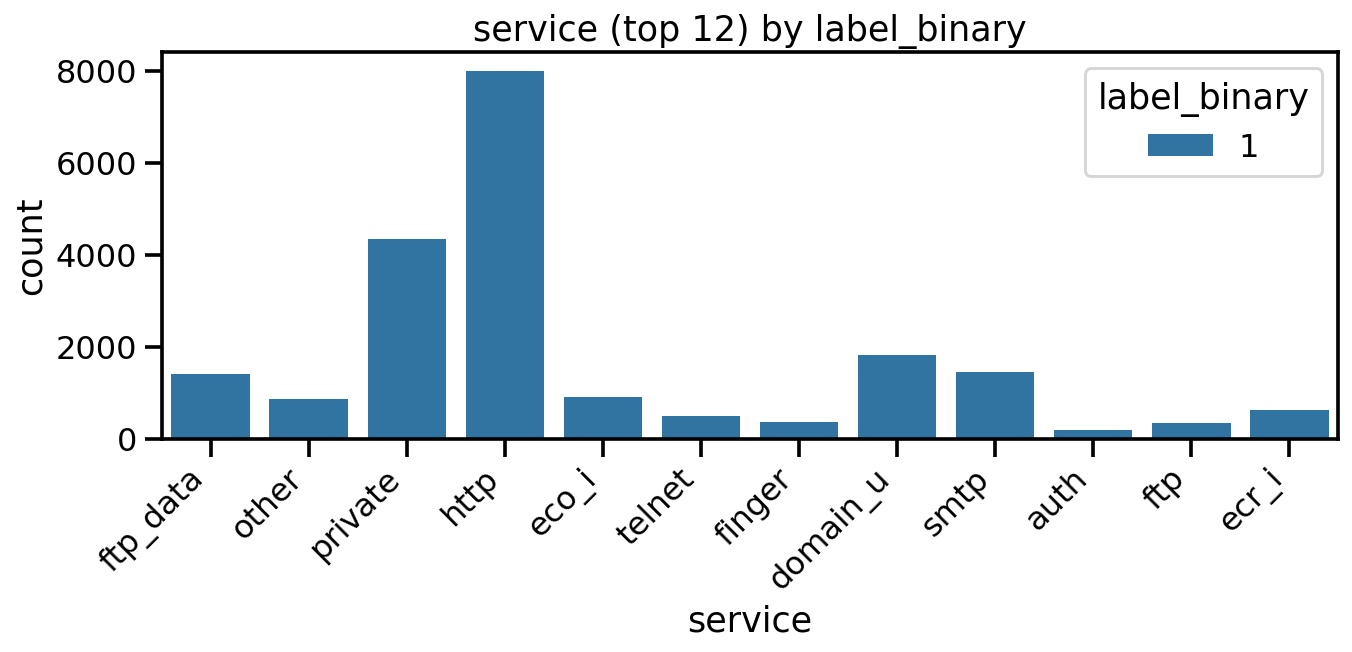

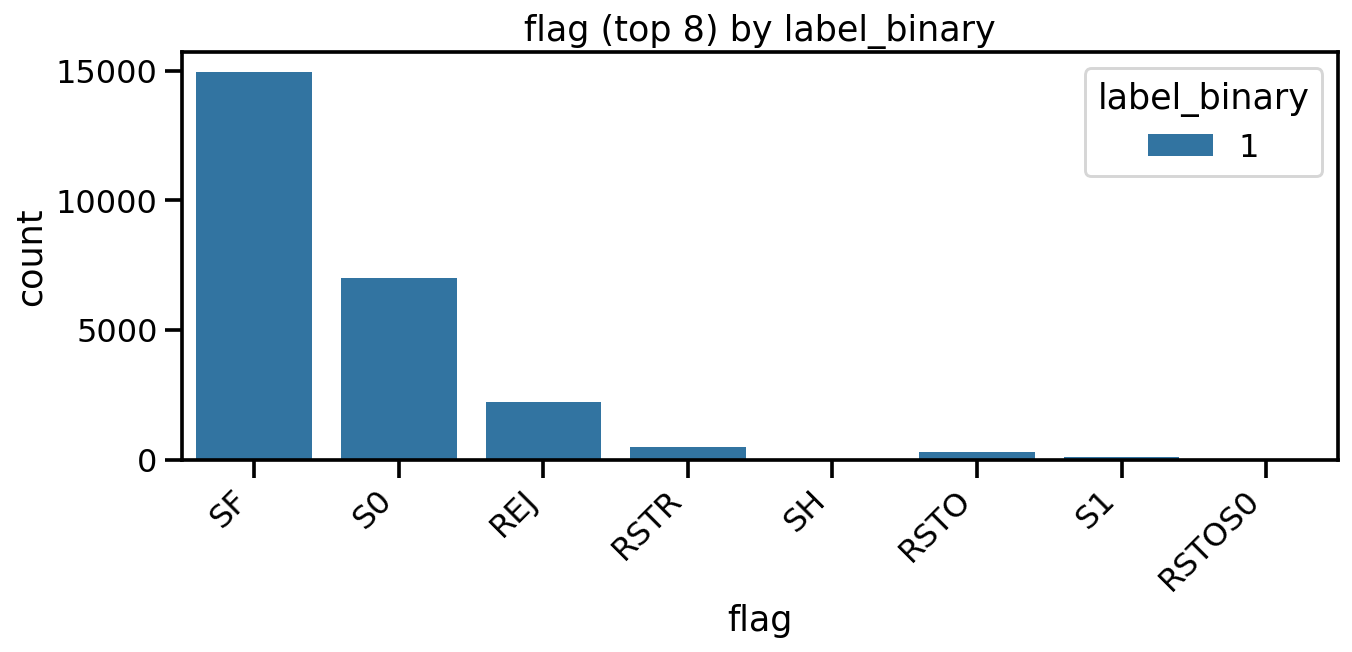

In [17]:
def cat_by_label(df, cat, hue, top_k=10, out="report/figs/cat_counts_by_label.png"):
    vc = df[cat].value_counts().head(top_k).index
    tmp = df[df[cat].isin(vc)]
    plt.figure(figsize=(10,5))
    sns.countplot(data=tmp, x=cat, hue=hue)
    plt.title(f"{cat} (top {top_k}) by {hue}")
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout(); plt.savefig(out); plt.show()

cat_by_label(raw_df, "service", "label_binary", top_k=12, out="report/figs/service_by_binary.png")
cat_by_label(raw_df, "flag", "label_binary", top_k=8, out="report/figs/flag_by_binary.png")


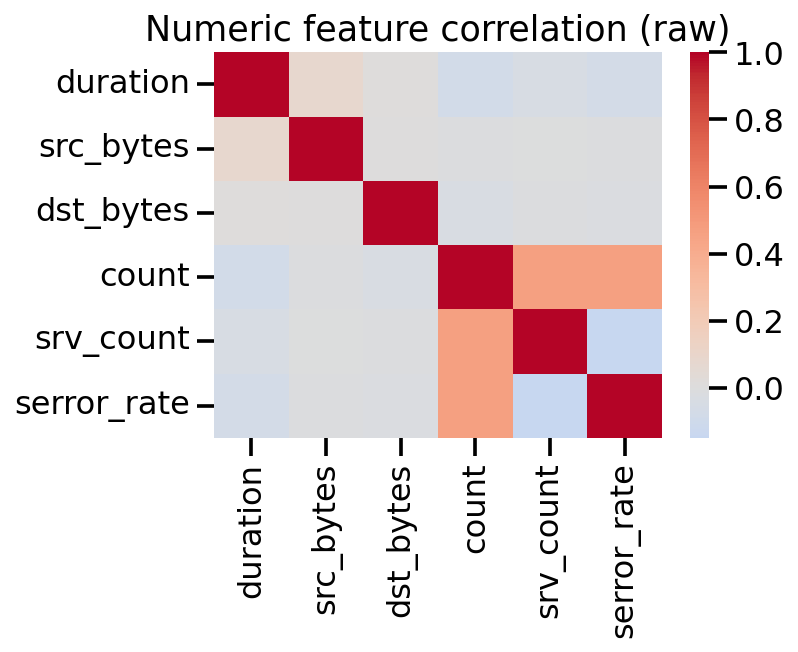

In [18]:
corr = raw_df[num_cols].corr()
plt.figure(figsize=(6,5))
sns.heatmap(corr, annot=False, cmap="coolwarm", center=0)
plt.title("Numeric feature correlation (raw)")
plt.tight_layout(); plt.savefig("report/figs/corr_numeric_raw.png"); plt.show()
